In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:",path)

Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


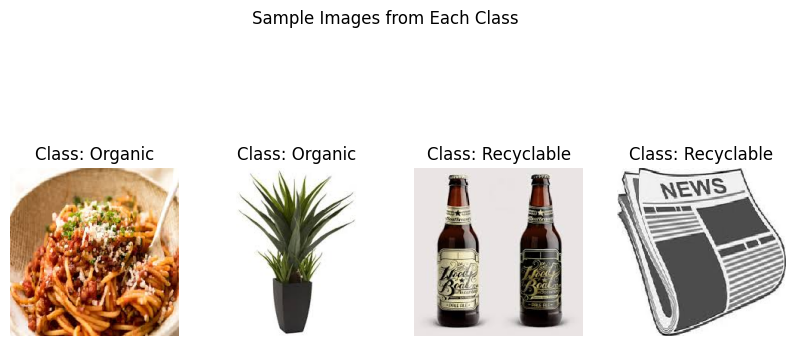

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up paths to the train and test directories
train_dir = r"/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TRAIN"
test_dir = r"/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TEST"

# Use ImageDataGenerator to prepare the data for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Display sample images from each class
plt.figure(figsize=(10, 5))
for i in range(4):  # Display 4 images (2 from each class if available)
    image, label = next(train_data)  # Use next() to get a batch of images
    plt.subplot(1, 4, i + 1)
    plt.imshow(image[0])  # Display the first image in the batch
    plt.title("Class: " + ("Organic" if label[0] == 0 else "Recyclable"))
    plt.axis('off')
plt.suptitle("Sample Images from Each Class")
plt.show()

In [ ]:
#include_top=False: Excludes the fully connected layers at the top of MobileNetV2
#weights='imagenet': Uses pre-trained weights from the ImageNet dataset
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freezes all the layers in the pre-trained MobileNetV2 to ensures that only the custom layers willlearn from new data
mobilenet_model.trainable = False

# Add custom layers for classification
model = tf.keras.Sequential([
    mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(), #reduces the spatial dimensions of single vector(summation of matrix)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# We start with a pre-trained MobileNet model, adding layers to classify waste images into O or R

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=3,

)

model.save('mobilenet_waste_classification.h5')

loss, accuracy = model.evaluate(test_data)
print("Model Accuracy:", accuracy)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


706/706 ━━━━━━━━━━━━━━━━━━━━ 1186s 2s/step - accuracy: 0.8701 - loss: 0.3006 - val_accuracy: 0.8961 - val_loss: 0.2515
Epoch 2/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 1203s 2s/step - accuracy: 0.9347 - loss: 0.1722 - val_accuracy: 0.9125 - val_loss: 0.2216
Epoch 3/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 1151s 2s/step - accuracy: 0.9380 - loss: 0.1650 - val_accuracy: 0.9005 - val_loss: 0.2460


79/79 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9049 - loss: 0.2327
Model Accuracy: 0.9005172848701477


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step
Classification Report:
               precision    recall  f1-score   support

     Organic       0.55      0.61      0.58      1401
  Recyclable       0.43      0.37      0.40      1112

    accuracy                           0.50      2513
   macro avg       0.49      0.49      0.49      2513
weighted avg       0.50      0.50      0.50      2513

Confusion Matrix:
 [[855 546]
 [698 414]]


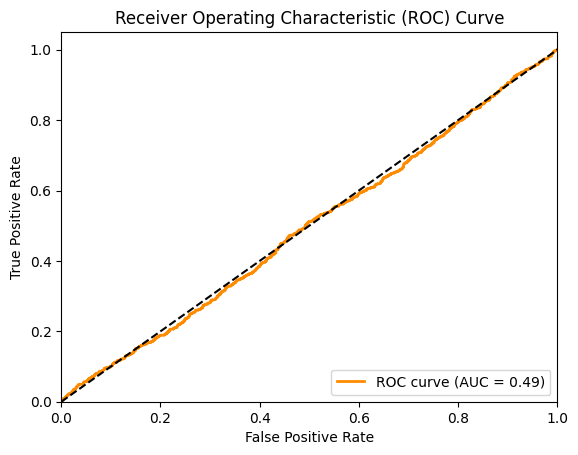

In [8]:
#Evaluation

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Generate predictions
y_pred_prob = model.predict(test_data).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
y_true = test_data.classes  # True labels from test data

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Organic', 'Recyclable']))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


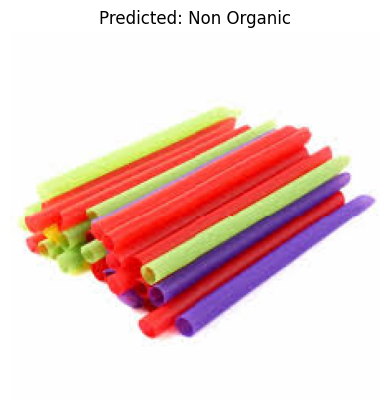

In [14]:
#Testing

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the trained model and test image
model_path = 'mobilenet_waste_classification.h5'  # Corrected the model path
# Update test_image_path with the correct absolute path to the image
test_image_path = r"/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TEST/R/R_10399.jpg"

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Load and prepare the test image
test_img = load_img(test_image_path, target_size=(224, 224))  # Load image and resize
test_img_array = img_to_array(test_img) / 255.0  # Normalize pixel values
test_img_array = np.expand_dims(test_img_array, axis=0)  # Add batch dimension

# Predict the class of the test image
predicted_prob = model.predict(test_img_array)[0][0]
predicted_class = 'Organic' if predicted_prob < 0.5 else 'Non Organic'

# Display the test image and prediction
plt.imshow(test_img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

In [11]:
# Path to the trained model and test image
model_path = 'mobilenet_waste_classification.h5'  # Corrected the model path
test_image_path = r"Dataset/Test/R/R_10399.jpg"

# Load the trained model
model = tf.keras.models.load_model(model_path)

# ... (Rest of your code remains the same)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Generate prediction
y_pred_prob = model.predict(test_data).flatten()
y_pred = (y_pred_prob >0.5).astype(int) #convert probabilities to binary predictions
y_true = test_data.classes #true labels from test data

#print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Organic','Recycable']))

#print confusion matrix
conf_matrix=confusion_matrix(y_true, y_pred) # Changed 'cunfusion_matrix' to 'confusion_matrix'
print("Confusion Matrix:\n", conf_matrix)

#ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)
y_pred_prob = model.predict(test_data).flatten()
y_pred = (y_pred_prob >0.5).astype(int) #convert probabilities to binary predictions
y_true = test_data.classes #true labels from test data

#print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Organic','Recycable']))

#print confusion matrix
conf_matrix=confusion_matrix(y_true, y_pred) # Changed 'cunfusion_matrix' to 'confusion_matrix'
print("Confusion Matrix:\n", conf_matrix)

#ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)

79/79 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step
Classification Report:
               precision    recall  f1-score   support

     Organic       0.55      0.61      0.58      1401
   Recycable       0.43      0.38      0.40      1112

    accuracy                           0.51      2513
   macro avg       0.49      0.49      0.49      2513
weighted avg       0.50      0.51      0.50      2513

Confusion Matrix:
 [[858 543]
 [695 417]]
AUC:  0.4874274028314821
79/79 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step
Classification Report:
               precision    recall  f1-score   support

     Organic       0.56      0.62      0.58      1401
   Recycable       0.44      0.38      0.41      1112

    accuracy                           0.51      2513
   macro avg       0.50      0.50      0.50      2513
weighted avg       0.50      0.51      0.51      2513

Confusion Matrix:
 [[863 538]
 [690 422]]
AUC:  0.49940946600321456
